## 線形回帰

### 正規方程式

In [5]:
import numpy as np

X = 2 * np.random.rand(100,1)
y = 4 + 3 * X + np.random.randn(100,1)

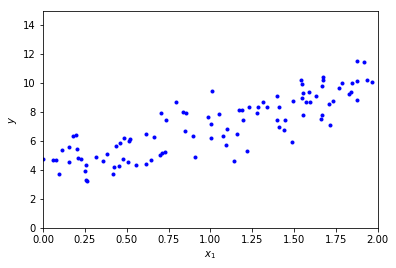

In [14]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

plt.plot(X, y, 'b.')
plt.xlabel('$x_1$')
plt.ylabel('$y$')
plt.axis([0, 2, 0, 15])
plt.show()

In [15]:
X_b = np.c_[np.ones((100, 1)), X]
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

In [16]:
theta_best

array([[ 3.98199857],
       [ 3.00923117]])

In [21]:
# x1が0と2の時を予測してみる
X_new = np.array([[0],[2]])
X_new_b = np.c_[np.ones((2, 1)), X_new]
y_predict = X_new_b.dot(theta_best)
y_predict

array([[  3.98199857],
       [ 10.00046091]])

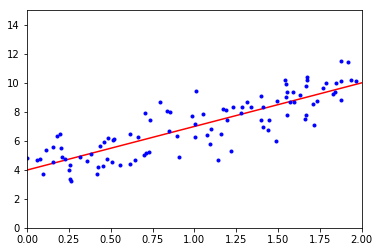

In [31]:
plt.plot(X_new, y_predict, "r-")
plt.plot(X, y, "b.")
plt.axis([0, 2, 0, 15])
plt.show()

In [38]:
# scikit-learnを使った場合
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([ 3.98199857]), array([[ 3.00923117]]))

In [39]:
lin_reg.predict(X_new)

array([[  3.98199857],
       [ 10.00046091]])

### 勾配降下法